In [ ]:
# 安装最新版本的所有依赖，避免版本冲突
!pip install --upgrade ragas
!pip install --upgrade langchain
!pip install --upgrade langchain-core
!pip install --upgrade langchain-openai
!pip install --upgrade openai
!pip install pandas numpy matplotlib seaborn datasets

# 验证安装
print("\n" + "="*60)
print("Verifying installations...")
print("="*60)

try:
    import ragas
    print(f"✓ RAGAS version: {ragas.__version__}")
except ImportError as e:
    print(f"✗ RAGAS import failed: {e}")

try:
    import openai
    print(f"✓ OpenAI version: {openai.__version__}")
except ImportError as e:
    print(f"✗ OpenAI import failed: {e}")

try:
    from langchain_openai import ChatOpenAI, OpenAIEmbeddings
    print(f"✓ langchain_openai installed")
except ImportError as e:
    print(f"✗ langchain_openai import failed: {e}")

try:
    from datasets import Dataset
    print(f"✓ datasets installed")
except ImportError as e:
    print(f"✗ datasets import failed: {e}")

print("="*60)

In [ ]:
import pandas as pd
from datasets import Dataset

def prepare_ragas_dataset(df: pd.DataFrame, answer_column: str) -> Dataset:
    """
    准备RAGAS评估数据集
    
    医疗报告结构：
    - clinical_information: 患者临床信息（症状、病史等）
    - findings: 影像检查发现
    - impression: 影像学印象/诊断结论
    
    评估设置：
    - question: 构建明确的问题（基于临床信息生成诊断问题）
    - contexts: 提供findings作为上下文
    - answer: 模型生成的impression
    - ground_truth: 真实的impression
    """
    questions = []
    contexts = []
    
    for _, row in df.iterrows():
        # 构建明确的诊断问题
        clinical_info = str(row['clinical_information']).strip()
        findings = str(row['findings']).strip()
        
        # 创建更结构化的问题
        question = f"Based on the clinical information: {clinical_info}, what is the radiological impression?"
        
        # contexts应该是一个列表的列表，每个元素是一个context的列表
        context = [findings]  # 只使用findings作为上下文
        
        questions.append(question)
        contexts.append(context)
    
    data_dict = {
        'question': questions,
        'contexts': contexts,
        'answer': df[answer_column].fillna('').tolist(),
        'ground_truth': df['impression'].fillna('').tolist()
    }
    return Dataset.from_dict(data_dict)

# 读取单个CSV文件
comparison_df = pd.read_csv('lora_comparison_results.csv')

# 数据清洗：移除关键字段为空的行
print(f"Original dataset size: {len(comparison_df)}")

# 先填充NaN为空字符串，避免比较时出错
for col in ['clinical_information', 'findings', 'impression', 'base_model_answer', 'lora_model_answer']:
    if col in comparison_df.columns:
        comparison_df[col] = comparison_df[col].fillna('')

# 移除空值行
comparison_df = comparison_df[
    (comparison_df['clinical_information'].astype(str).str.strip() != '') &
    (comparison_df['findings'].astype(str).str.strip() != '') &
    (comparison_df['impression'].astype(str).str.strip() != '') &
    (comparison_df['base_model_answer'].astype(str).str.strip() != '') &
    (comparison_df['lora_model_answer'].astype(str).str.strip() != '')
]

print(f"Cleaned dataset size: {len(comparison_df)}")

if len(comparison_df) == 0:
    raise ValueError("No valid data after cleaning! Please check your CSV file.")

# 使用同一个DataFrame的不同列准备两个数据集
baseline_dataset = prepare_ragas_dataset(comparison_df, 'base_model_answer')
lora_dataset = prepare_ragas_dataset(comparison_df, 'lora_model_answer')

print("\nDatasets prepared for evaluation.")
print("\n=== Sample Data ===")
print(f"Question: {baseline_dataset[0]['question']}")
print(f"\nContexts: {baseline_dataset[0]['contexts']}")
print(f"\nBase Answer (first 200 chars): {baseline_dataset[0]['answer'][:200]}...")
print(f"\nGround Truth (first 200 chars): {baseline_dataset[0]['ground_truth'][:200]}...")

# 验证数据结构
print("\n=== Data Validation ===")
print(f"Number of samples: {len(baseline_dataset)}")
print(f"All questions non-empty: {all(len(q.strip()) > 0 for q in baseline_dataset['question'])}")
print(f"All contexts non-empty: {all(len(c[0].strip()) > 0 for c in baseline_dataset['contexts'])}")
print(f"All answers non-empty: {all(len(a.strip()) > 0 for a in baseline_dataset['answer'])}")
print(f"All ground_truths non-empty: {all(len(g.strip()) > 0 for g in baseline_dataset['ground_truth'])}")

In [ ]:
import os
from langchain_openai import ChatOpenAI, OpenAIEmbeddings

# 设置API密钥
os.environ["OPENAI_API_KEY"] = "YOUR_OPENAI_API_KEY"

# 配置RAGAS使用的LLM和Embeddings（最新版RAGAS的方式）
evaluator_llm = ChatOpenAI(model="gpt-3.5-turbo", temperature=0)
evaluator_embeddings = OpenAIEmbeddings()

print("✓ API Key configured")
print(f"✓ Evaluator LLM: {evaluator_llm.model_name}")
print(f"✓ Evaluator Embeddings: OpenAIEmbeddings")

In [ ]:
# 测试单个样本的评估，找出具体问题
from ragas import evaluate
from ragas.metrics import answer_correctness, answer_similarity, answer_relevancy

print("Testing individual metrics on a single sample...")
print("=" * 60)

# 创建只有一个样本的测试数据集
test_sample = Dataset.from_dict({
    'question': [baseline_dataset[0]['question']],
    'contexts': [baseline_dataset[0]['contexts']],
    'answer': [baseline_dataset[0]['answer']],
    'ground_truth': [baseline_dataset[0]['ground_truth']]
})

print("\nTest sample data:")
print(f"Question: {test_sample[0]['question'][:150]}...")
print(f"Answer length: {len(test_sample[0]['answer'])} chars")
print(f"Ground truth length: {len(test_sample[0]['ground_truth'])} chars")

# 逐个测试指标 - 使用最新RAGAS API
print("\n" + "=" * 60)
print("Testing Answer Similarity...")
try:
    result = evaluate(
        test_sample, 
        metrics=[answer_similarity],
        llm=evaluator_llm,
        embeddings=evaluator_embeddings
    )
    print(f"✓ Answer Similarity: {result['answer_similarity']}")
except Exception as e:
    print(f"✗ Answer Similarity failed: {e}")
    import traceback
    traceback.print_exc()

print("\n" + "=" * 60)
print("Testing Answer Correctness...")
try:
    result = evaluate(
        test_sample, 
        metrics=[answer_correctness],
        llm=evaluator_llm,
        embeddings=evaluator_embeddings
    )
    print(f"✓ Answer Correctness: {result['answer_correctness']}")
except Exception as e:
    print(f"✗ Answer Correctness failed: {e}")
    import traceback
    traceback.print_exc()

print("\n" + "=" * 60)
print("Testing Answer Relevancy...")
try:
    result = evaluate(
        test_sample, 
        metrics=[answer_relevancy],
        llm=evaluator_llm,
        embeddings=evaluator_embeddings
    )
    print(f"✓ Answer Relevancy: {result['answer_relevancy']}")
except Exception as e:
    print(f"✗ Answer Relevancy failed: {e}")
    import traceback
    traceback.print_exc()

In [ ]:
from ragas import evaluate
from ragas.metrics import (
    answer_correctness,
    answer_similarity,
    answer_relevancy
)

# evaluating the models using the RAGAS metrics.
def evaluate_model(dataset: Dataset, model_name: str):
    print(f"\nEvaluating {model_name}...")
    
    metrics = [
        answer_correctness,
        answer_similarity,
        answer_relevancy
    ]
    
    results = evaluate(
        dataset=dataset,
        metrics=metrics,
        llm=evaluator_llm,
        embeddings=evaluator_embeddings
    )
    
    return results


print("Running RAGAS evaluations with configured LLM...")
baseline_results = evaluate_model(baseline_dataset, "Base Model")
lora_results = evaluate_model(lora_dataset, "LoRA Model")


--------------------------------------------------
BASELINE MODEL RESULTS
--------------------------------------------------
{'answer_correctness': 0.5392, 'answer_similarity': 0.9228, 'answer_relevancy': 0.8049}

--------------------------------------------------
LoRA MODEL RESULTS
--------------------------------------------------
{'answer_correctness': 0.5780, 'answer_similarity': 0.9240, 'answer_relevancy': 0.7143}

--------------------------------------------------
Metrics comparison (mean scores)
--------------------------------------------------
            Metric  Baseline     LoRA
Answer Correctness  0.539246 0.578004
 Answer Similarity  0.922773 0.924008
  Answer Relevancy  0.804855 0.714279

--------------------------------------------------
Detailed comparison with improvement.
--------------------------------------------------
            Metric  Baseline     LoRA  Improvement (%)
Answer Correctness  0.539246 0.578004             7.19
 Answer Similarity  0.922773 0.924008

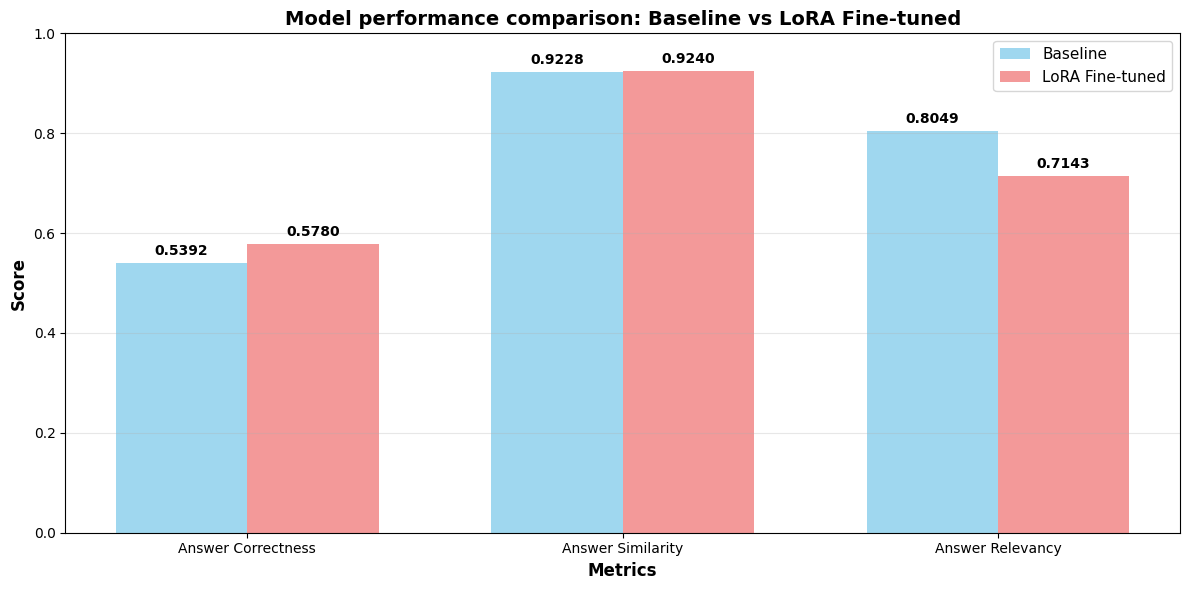


--------------------------------------------------
Summary.
--------------------------------------------------
Average Baseline score: 0.7556
Average LoRA score: 0.7388
Overall improvement: -2.23%

--------------------------------------------------
Per-metric improvement.
--------------------------------------------------
Answer Correctness: increased 7.19%
Answer Similarity: increased 0.13%
Answer Relevancy: decreased 11.25%


In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np


print("\n" + "-"*50)
print("BASELINE MODEL RESULTS")
print("-"*50)
print(baseline_results)

print("\n" + "-"*50)
print("LoRA MODEL RESULTS")
print("-"*50)
print(lora_results)

# mean score.
def get_mean_score(results, metric_name):
    value = results[metric_name]
    if isinstance(value, list):
        return np.mean(value)
    return value

# comparing metrics by calculating the means.
metrics_comparison = pd.DataFrame({
    'Metric': ['Answer Correctness', 'Answer Similarity', 'Answer Relevancy'],
    'Baseline': [
        get_mean_score(baseline_results, 'answer_correctness'),
        get_mean_score(baseline_results, 'answer_similarity'),
        get_mean_score(baseline_results, 'answer_relevancy')
    ],
    'LoRA': [
        get_mean_score(lora_results, 'answer_correctness'),
        get_mean_score(lora_results, 'answer_similarity'),
        get_mean_score(lora_results, 'answer_relevancy')
    ]
})

print("\n" + "-"*50)
print("Metrics comparison (mean scores)")
print("-"*50)
print(metrics_comparison.to_string(index=False))

# caluclating improvement.
metrics_comparison['Improvement (%)'] = ((metrics_comparison['LoRA'] - metrics_comparison['Baseline']) / metrics_comparison['Baseline'] * 100).round(2)

print("\n" + "-"*50)
print("Detailed comparison with improvement.")
print("-"*50)
print(metrics_comparison.to_string(index=False))

fig, ax = plt.subplots(figsize=(12, 6))
x = range(len(metrics_comparison))
width = 0.35

baseline_bars = ax.bar([i - width/2 for i in x], metrics_comparison['Baseline'],
                        width, label='Baseline', alpha=0.8, color='skyblue')
lora_bars = ax.bar([i + width/2 for i in x], metrics_comparison['LoRA'],
                    width, label='LoRA Fine-tuned', alpha=0.8, color='lightcoral')

ax.set_xlabel('Metrics', fontsize=12, fontweight='bold')
ax.set_ylabel('Score', fontsize=12, fontweight='bold')
ax.set_title('Model performance comparison: Baseline vs LoRA Fine-tuned', fontsize=14, fontweight='bold')
ax.set_xticks(x)
ax.set_xticklabels(metrics_comparison['Metric'], rotation=0, ha='center')
ax.legend(fontsize=11)
ax.grid(axis='y', alpha=0.3)
ax.set_ylim([0, 1])

for bars in [baseline_bars, lora_bars]:
    for bar in bars:
        height = bar.get_height()
        ax.text(bar.get_x() + bar.get_width()/2., height + 0.01,
                f'{height:.4f}',
                ha='center', va='bottom', fontsize=10, fontweight='bold')

plt.tight_layout()
plt.show()

# statistics.
print("\n" + "-"*50)
print("Summary.")
print("-"*50)
avg_baseline = metrics_comparison['Baseline'].mean()
avg_lora = metrics_comparison['LoRA'].mean()
overall_improvement = ((avg_lora - avg_baseline) / avg_baseline * 100)

print(f"Average Baseline score: {avg_baseline:.4f}")
print(f"Average LoRA score: {avg_lora:.4f}")
print(f"Overall improvement: {overall_improvement:.2f}%")

print("\n" + "-"*50)
print("Per-metric improvement.")
print("-"*50)
for idx, row in metrics_comparison.iterrows():
    improvement = row['Improvement (%)']
    direction = "increased" if improvement > 0 else "decreased"
    print(f"{row['Metric']}: {direction} {abs(improvement):.2f}%")